In [1]:
import pickle
import os
import sensus

import open3d as o3d
import numpy as np

from sensus.utils.data_converter import pc2pc_object
from open3d.web_visualizer import draw
from mmdetection3d import data, demo, configs, checkpoints
from sensus import configs as sensus_configs
from matplotlib import pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2023-04-03 23:45:54,317 - instantiator - Created a temporary directory at /tmp/tmp7756c4dn
INFO - 2023-04-03 23:45:54,319 - instantiator - Writing /tmp/tmp7756c4dn/_remote_module_non_scriptable.py


[Open3D INFO] Resetting default logger to print to terminal.


# Preprocess

In [22]:
# Read pickle file lidar.pickle from data directory
with open(os.path.join(sensus.__path__[0], 'data/lidar.pickle'), 'rb') as f:
    lidar_pickle = pickle.load(f)

In [23]:
pc_buffer = np.frombuffer(lidar_pickle.data,
                    dtype=[('x', np.float32), ('y', np.float32), ('z', np.float32), ('intensity', np.float32)],
                    count=lidar_pickle.width*lidar_pickle.height, offset=0)
pc_ros = pc_buffer.view(dtype=np.float32).reshape(pc_buffer.shape[0], -1)
pc_ros[:, 2] = pc_ros[:, 2] + 4

In [24]:
pc_ros.min(axis=0)

array([-116.592995  , -115.0505    ,   -4.008335  ,    0.61992574],
      dtype=float32)

In [4]:
lidar_pickle.header

std_msgs.msg.Header(stamp=builtin_interfaces.msg.Time(sec=1678708072, nanosec=670079821), frame_id='velodyne_64')

# Inference

In [5]:
from mmdet3d.apis import inference_detector, init_model
from mmdet3d.utils import register_all_modules

In [15]:
register_all_modules()
model_cfg = os.path.join(sensus_configs.__path__[0],
    'second/second_hv_secfpn_8xb6-80e_kitti-3d-3class-ros.py')
checkpoint_path = os.path.join(checkpoints.__path__[0],
    'hv_second_secfpn_6x8_80e_kitti-3d-3class_20210831_022017-ae782e87.pth')
device = 'cuda:0'

model = init_model(model_cfg, checkpoint_path, device=device)

Loads checkpoint by local backend from path: /home/messi/alvaro/sensus-loci/mmdetection3d/checkpoints/hv_second_secfpn_6x8_80e_kitti-3d-3class_20210831_022017-ae782e87.pth


In [25]:
# Print the max and min values of each column in the point cloud
print(np.max(pc_ros, axis=0))
print(np.min(pc_ros, axis=0))

[115.05504    115.06092     -0.7852335    0.95542234]
[-116.592995   -115.0505       -4.008335      0.61992574]


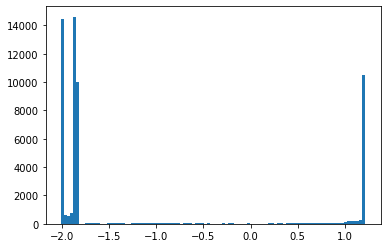

In [10]:
plt.hist(pc_ros[:, 2], bins=100);

In [26]:
# ROS
pc_object_ros, _ = pc2pc_object(pc_ros.flatten(), model.cfg.test_pipeline)
result_ros, _ = inference_detector(model, pc_object_ros)

In [27]:
result_ros.pred_instances_3d.bboxes_3d.tensor[:, 3]

tensor([3.7958, 3.9464, 3.9309, 4.1214, 3.9764, 3.8614, 4.0339, 3.8712],
       device='cuda:0')

In [ ]:
# z + 5
52.1288, -30.7273,  -2.8131,   4.2216,   1.7148,   1.5176,   2.8515
# z + 6

In [97]:
result

<Det3DDataSample(

    META INFORMATION
    pcd_rotation: tensor([[1., 0., 0.],
                [-0., 1., 0.],
                [0., 0., 1.]])
    box_type_3d: <class 'mmdet3d.structures.bbox_3d.lidar_box3d.LiDARInstance3DBoxes'>
    pcd_rotation_angle: 0.0
    pcd_horizontal_flip: False
    box_mode_3d: <Box3DMode.LIDAR: 0>
    pcd_trans: array([0., 0., 0.])
    pcd_vertical_flip: False
    transformation_3d_flow: ['R', 'S', 'T']
    pcd_scale_factor: 1.0
    flip: False

    DATA FIELDS
    pred_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
        ) at 0x7fda4b377d90>
    gt_pts_seg: <PointData(
        
            META INFORMATION
        
            DATA FIELDS
        ) at 0x7fda4b2c7730>
    gt_instances_3d: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
        ) at 0x7fda4b2c73d0>
    pred_instances_3d: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS

In [30]:
# print(result_ros.pred_instances_3d.labels_3d)
# print(result_ros.pred_instances_3d.scores_3d)
# print(result_ros.pred_instances_3d.bboxes_3d)
print(result_ros.pred_instances_3d.bboxes_3d.tensor[0])
print(result_ros.pred_instances_3d.bboxes_3d.tensor.shape)

tensor([  1.6682, -37.9861,  -2.6241,   4.3703,   1.7161,   1.5333,   3.2115],
       device='cuda:0')
torch.Size([18, 7])


In [8]:
# Same result after processing points (maybe processing under the hood when
# using np.array pc)
points = points.reshape(-1, 4)
result, data = inference_detector(model, points)

AttributeError: 'numpy.ndarray' object has no attribute 'rotate'

In [71]:
print(result.pred_instances_3d.labels_3d)
print(result.pred_instances_3d.scores_3d)
print(result.pred_instances_3d.bboxes_3d.tensor.shape)

tensor([0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
tensor([0.1304, 0.1173, 0.3624, 0.3572, 0.9088, 0.8917, 0.8498, 0.7471, 0.7245,
        0.6414, 0.6307, 0.5603, 0.4316, 0.3937], device='cuda:0')
torch.Size([14, 7])


# Visualization

In [11]:
bin_path = os.path.join(demo.__path__[0],
    'data/kitti/000008.bin')
pc_path = os.path.join(
    '/home/messi/alvaro/sensus-loci/mmdetection3d/demo/kitti_pointpillars/kitti_000008',
    'kitti_000008_points.obj')
bboxes_path = os.path.join(
    '/home/messi/alvaro/sensus-loci/mmdetection3d/demo/kitti_pointpillars/kitti_000008',
    'kitti_000008_pred.obj')

In [12]:
# Read pc from bin file
with open(bin_path, 'rb') as f:
    points = np.fromfile(f, dtype=np.float32, count=-1).reshape([-1, 4])

pcd_bin = o3d.geometry.PointCloud()
pcd_bin.points = o3d.utility.Vector3dVector(points[:, :3])
print(pcd_bin)

PointCloud with 17238 points.


In [5]:
# Read pc from obj file (reading with o3d.io.read_triangle_mesh or 
# read_point_cloud does not work)
pc = []
with open(pc_path, 'rb') as f:
    for each in f.readlines():
        p1, p2, p3 = each.decode('utf-8').split(' ')[1:]
        pc.append([float(p1), float(p2), float(p3.replace('\n', ''))])

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.array(pc))
print(pcd)

bboxes = o3d.io.read_triangle_mesh(bboxes_path)
bboxes.compute_vertex_normals()     # For solid rendering with lighting
bboxes_lines = o3d.geometry.LineSet().create_from_triangle_mesh(bboxes)
bboxes_lines.paint_uniform_color([1, 0, 0])
print(bboxes_lines)

PointCloud with 16897 points.
LineSet with 360 lines.


In [29]:
draw([pcd, bboxes_lines], width=900, height=600, point_size=2)

WebVisualizer(window_uid='window_11')

In [13]:
draw([pcd_bin, bboxes_lines], width=900, height=600, point_size=2)

WebVisualizer(window_uid='window_0')